# Variable environments

# Archived, some old code chunks

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

import helper


In [62]:
root="results_testing_L1_01_good"
#root="results_new_rules"

def try_grn(variable, rule, run_seedints, try_seedints, grn_size, geneid):
    last_grns=[]
    for i in range(5):
        if variable:
            filename = f"{root}/stats_300_{rule}-{rule}_{run_seedints[0]}-{run_seedints[1]}_{i+1}" + "_best_grn.txt"
        else:
            if rule in [154,82,86,18]:
                filename = f"results_new_rules/stats_0_{rule}_{run_seedints}_{i+1}" + "_best_grn.txt"
            else:
                filename = f"results_new_rules/stats_600_{rule}_{run_seedints}_{i+1}" + "_best_grn.txt"
        grns = np.loadtxt(filename)
        num_grns = int(grns.shape[0]/(grn_size+2)/grn_size)
        grns = grns.reshape(num_grns,grn_size+2,grn_size)
        grn = grns[-1,:,:]
        last_grns.append(grn)
    last_grns = np.array(last_grns)

    last_phenos=[]
    fits = []
    for s in try_seedints:
        targets, phenos, fitnesses = helper.get_pop_TPF(last_grns, len(last_grns), num_cells, grn_size, dev_steps, geneid, rule, s)
        last_phenos.append(phenos)
        fits.append(fitnesses)
    last_phenos = np.array(last_phenos)
    fits = np.array(fits)
    return last_phenos, fits, last_grns

In [63]:
# Load GRN

# Parameters
rule = 86
grn_size = 22
num_cells = 22
dev_steps = 22
geneid = 1 #which gene was used to get fitness
seed_ints = [69904,149796]
try_seedints = [69904,149796,1024, 4147842,1238860,2481300]

#Targets
all_targs=[]
for s in try_seedints:
    random_grns=np.random.randn(5, grn_size+2, grn_size).astype(np.float64)
    targets, phenos, fitnesses = helper.get_pop_TPF(random_grns, len(random_grns), num_cells, grn_size, dev_steps, geneid, rule, s)
    all_targs.append(targets)

#Check GRNs from the last generation
varied_phenos, varied_fits, varied_genos = try_grn(True, rule, seed_ints, try_seedints, grn_size, geneid)
env1_phenos, env1_fits, env1_genos = try_grn(False, rule, seed_ints[0], try_seedints, grn_size, geneid)
env2_phenos, env2_fits, env2_genos = try_grn(False, rule, seed_ints[1], try_seedints, grn_size, geneid)

varied_df = pd.DataFrame(varied_fits.T, columns = try_seedints)
env1_df = pd.DataFrame(env1_fits.T, columns = try_seedints)
env2_df = pd.DataFrame(env2_fits.T, columns = try_seedints)
dfs=[varied_df, env1_df, env2_df]


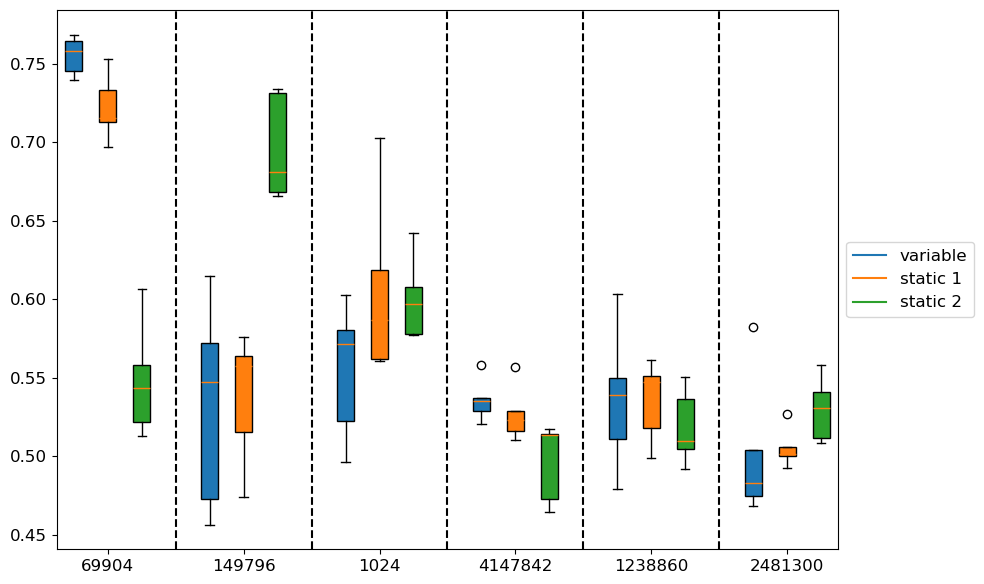

In [64]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['C0', 'C1', 'C2']
# Loop through each DataFrame and plot the boxplots
for i, df in enumerate(dfs):
    # Plot the boxplot, with positions offset for each dataframe
    bp = ax.boxplot(df.values, positions=np.arange(df.shape[1]) * (len(dfs) + 1) + i, patch_artist=True)
    # Set the box colors
    for box in bp['boxes']:
        box.set(facecolor=colors[i])
ax.set_xticks(np.arange(varied_df.shape[1]) * (len(dfs) + 1) + 1)
ax.set_xticklabels(varied_df.columns)

# Create legend for the colors
labels=["variable", "static 1", "static 2"]
for i, color in enumerate(colors):
    ax.plot([], c=color, label=labels[i])

# Add legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

for i in range(1, varied_df.shape[1]):
    # Position the line between each set
    x_position = i * (len(dfs) + 1) - 1
    ax.axvline(x=x_position, color='black', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Unseen')

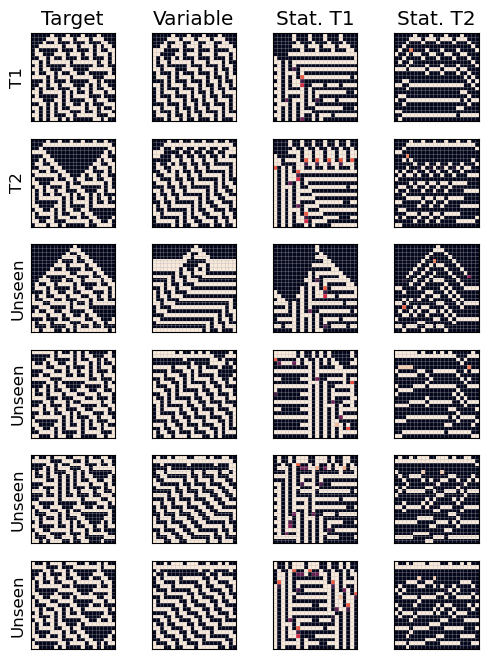

In [65]:
fig, axs = plt.subplots(6, 4, figsize=(6, 8), sharex=True, sharey=True)

plt.rcParams.update({"font.size": 12})

rep_id=0

for i in range(6):#looping through seeds
    helper.imshow_ca(all_targs[i], ax=axs[i,0])
    helper.imshow_ca(varied_phenos[i,rep_id,:,:], ax=axs[i,1])
    helper.imshow_ca(env1_phenos[i,rep_id,:,:], ax=axs[i,2])
    helper.imshow_ca(env2_phenos[i,rep_id,:,:], ax=axs[i,3])

axs[0,0].set_title('Target')
axs[0,1].set_title('Variable')
axs[0,2].set_title('Stat. T1')
axs[0,3].set_title('Stat. T2')

axs[0,0].set_ylabel("T1")
axs[1,0].set_ylabel("T2")
axs[2,0].set_ylabel("Unseen")
axs[3,0].set_ylabel("Unseen")
axs[4,0].set_ylabel("Unseen")
axs[5,0].set_ylabel("Unseen")

# The genomes

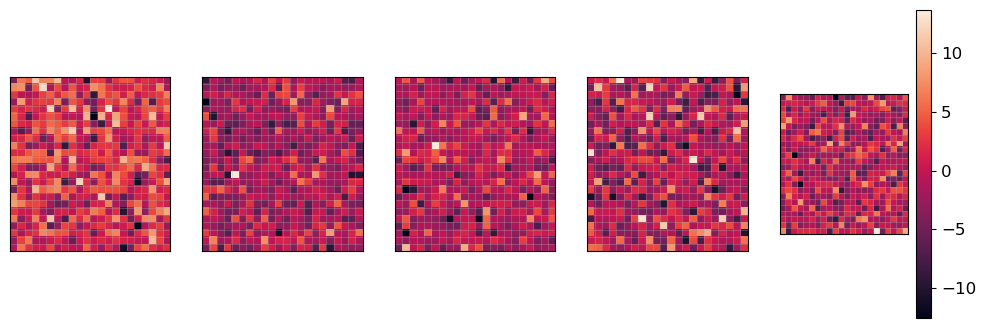

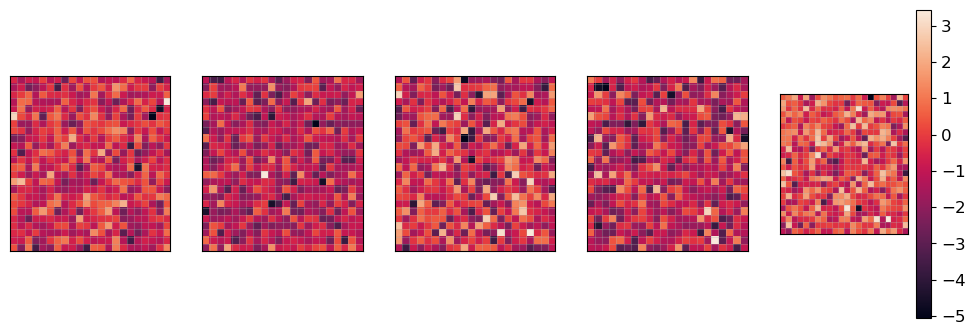

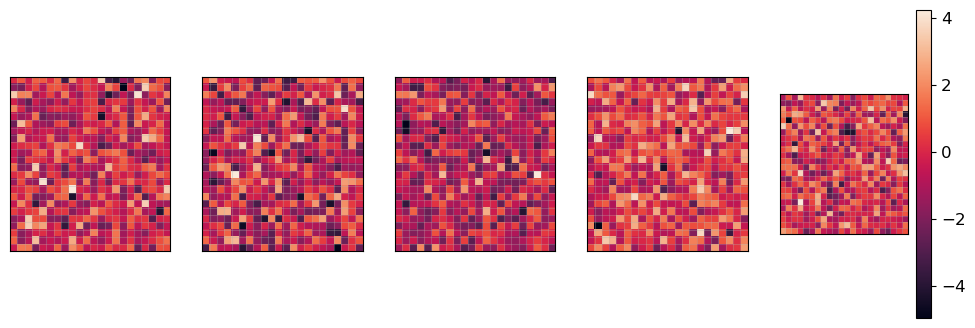

In [66]:
fig, axs = plt.subplots(ncols=5, nrows = 1, figsize=(12, 4))
for i,g in enumerate(varied_genos):
    im = helper.imshow_ca(g, ax=axs[i])
    if i == len(varied_genos)-1:
        fig.colorbar(im, ax=axs[-1])

fig, axs = plt.subplots(ncols=5, nrows = 1, figsize=(12, 4))
for i,g in enumerate(env1_genos):
    im = helper.imshow_ca(g, ax=axs[i])
    if i == len(env1_genos)-1:
        fig.colorbar(im, ax=axs[-1])

fig, axs = plt.subplots(ncols=5, nrows = 1, figsize=(12, 4))
for i,g in enumerate(env2_genos):
    im = helper.imshow_ca(g, ax=axs[i])
    if i == len(env2_genos)-1:
        fig.colorbar(im, ax=axs[-1])

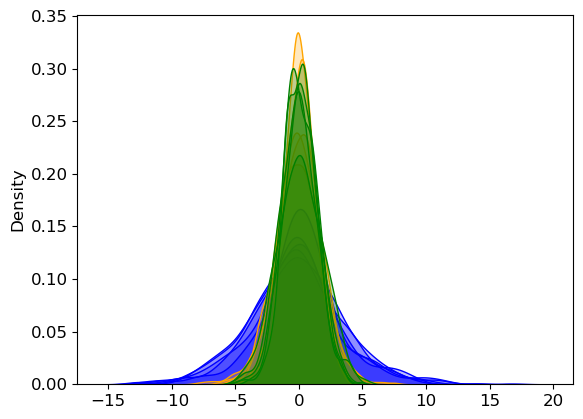

In [67]:
warnings.simplefilter(action='ignore', category=FutureWarning)
for i,g in enumerate(varied_genos):
    sns.kdeplot(g.flatten(),fill=True,color="blue")
for i,g in enumerate(env1_genos):
    sns.kdeplot(g.flatten(),fill=True,color="orange")
for i,g in enumerate(env2_genos):
    sns.kdeplot(g.flatten(),fill=True,color="green")
    

# Diversifiers

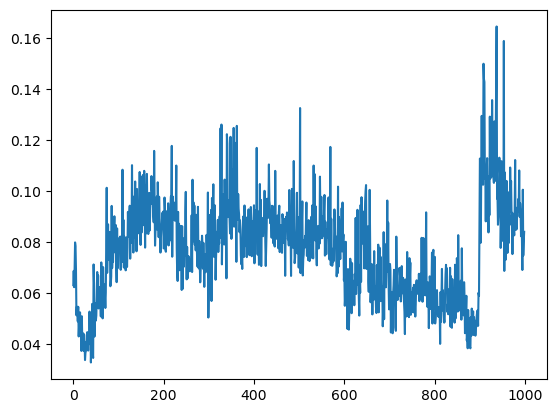

In [2]:
import os

root="results_testing_saving/"

season_len = 300
rules = [70,70]
rule = 70
seed_ints = [69904,149796]
metric = "beststd"

vari_beststds=[np.loadtxt(os.path.expanduser(root+f"stats_{season_len}_{rules[0]}-{rules[1]}_{seed_ints[0]}-{seed_ints[1]}_{i+1}_{metric}.txt")) for i in range(2)]

plt.plot(vari_beststds[0])

In [3]:
int_generation = np.argmax(vari_beststds[0])
vari_beststds[0][int_generation]

0.1646995952509189

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


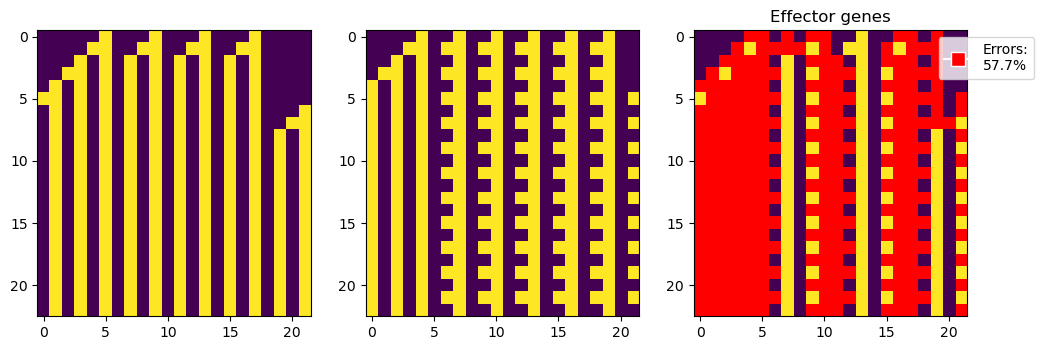

(1, 24, 22)


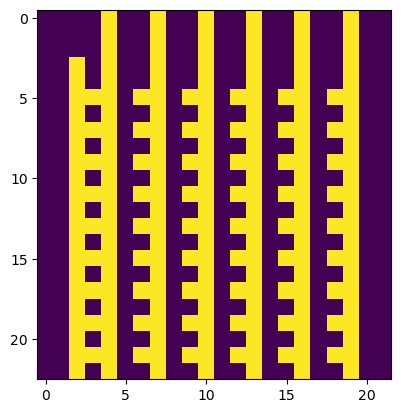

children


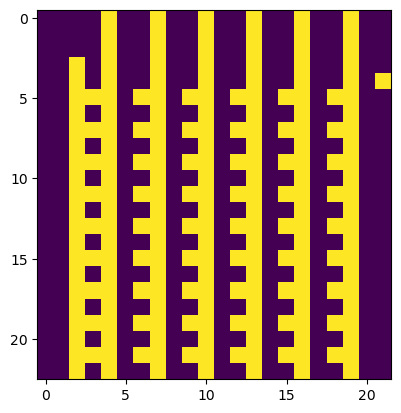

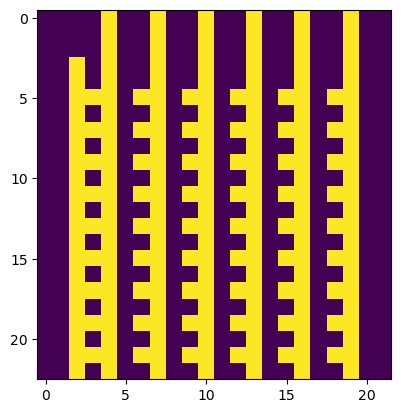

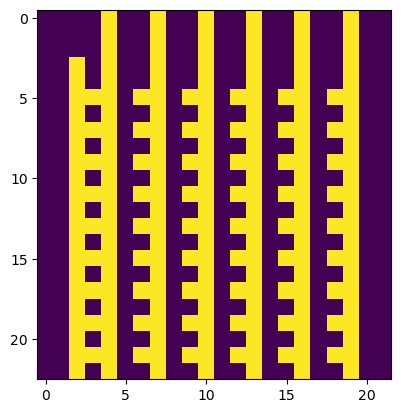

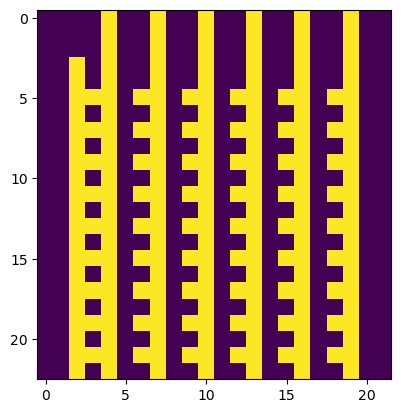

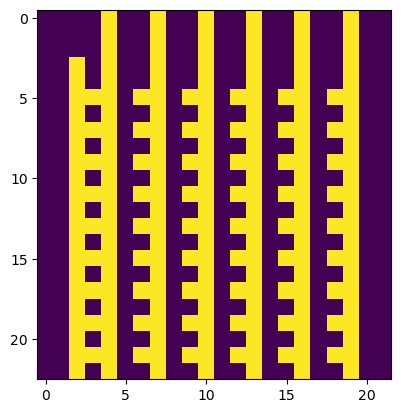

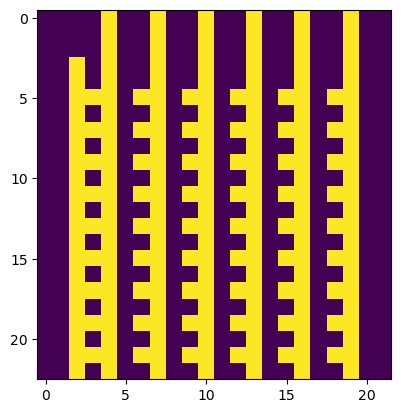

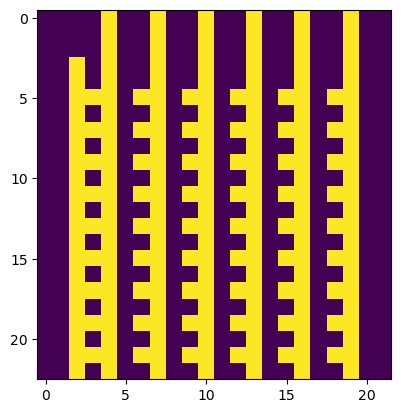

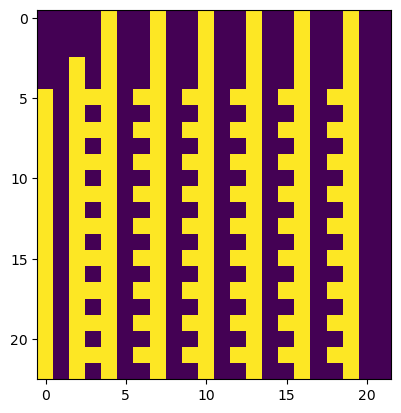

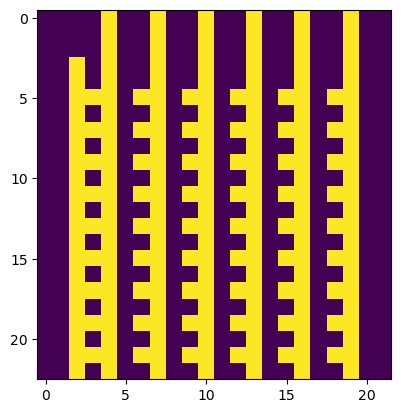

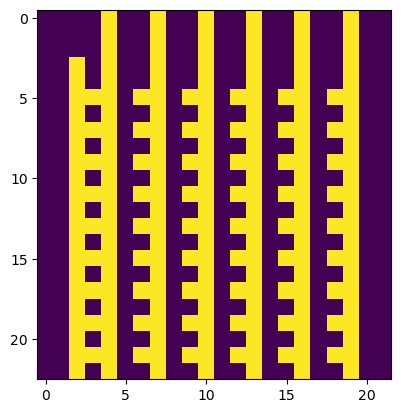

In [4]:
# Load GRN
# Parameters
grn_size = 22
num_cells = 22
dev_steps = 22
geneid = 1 #which gene was used to get fitness
mut_rate = 0.1
mut_size = 0.5
try_seedints = [69904,149796,1024, 4147842,1238860,2481300]

#Targets
all_targs=[]
for s in try_seedints:
    random_grns=np.random.randn(5, grn_size+2, grn_size).astype(np.float64)
    targets, phenos, fitnesses = helper.get_pop_TPF(random_grns, len(random_grns), num_cells, grn_size, dev_steps, geneid, rule, s)
    all_targs.append(targets)

fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
axs[0].imshow(all_targs[0])
axs[1].imshow(all_targs[1])
helper.show_effectors(all_targs[0], all_targs[1], M=0, ax=axs[2])
plt.show()

#Check GRNs
runid=0
filename = f"{root}/stats_300_{rule}-{rule}_{seed_ints[0]}-{seed_ints[1]}_{runid+1}" + "_best_grn_std.txt"
grns = np.loadtxt(filename)
num_grns = int(grns.shape[0]/(grn_size+2)/grn_size)
grns = grns.reshape(num_grns,grn_size+2,grn_size)
#int_generation = -1
grn = grns[int_generation,:,:]
if len(grn.shape) == 2:
    grn = np.expand_dims(grn, axis=0)
print(grn.shape)
targets, phenos, fitnesses = helper.get_pop_TPF(grn, len(grn), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[1])
plt.imshow(phenos[0])
plt.show()

#Make children
num_child = 10
num_genes_mutate = int((grn_size + 2) * grn_size * grn.shape[0] * mut_rate)
children = np.tile(grn, (num_child, 1, 1))

mutations = np.random.randn(num_genes_mutate) * mut_size
x, y, z = children.shape
xs = np.random.choice(x, size=num_genes_mutate)
ys = np.random.choice(y, size=num_genes_mutate)
zs = np.random.choice(z, size=num_genes_mutate)
children[xs, ys, zs] = children[xs, ys, zs] + mutations

all_phenos=[]
fits = []
for s in try_seedints:
    targets, phenos, fitnesses = helper.get_pop_TPF(children, len(children), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[1])
    all_phenos.append(phenos)
    fits.append(fitnesses)
all_phenos = np.array(all_phenos)
fits = np.array(fits)

print("children")
for p in all_phenos[0]:
    plt.imshow(p)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


70


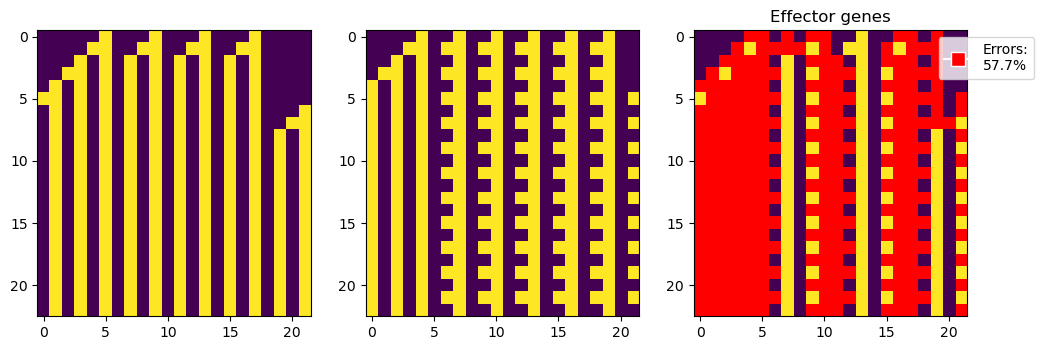

In [5]:
pop_size = 100
grn_size = 22
num_cells = 22
dev_steps = 22
geneid = 1
rule = 90
rules=[70]#[30,50,54,62,90,94,102,110,150,254,22, 126, 146, 154, 82, 86, 18, 118, 122, 70]

try_seedints = [69904,149796]

for r in rules:
    print(r)
    all_targs=[]
    for s in try_seedints:
        random_grns=np.random.randn(5, grn_size+2, grn_size).astype(np.float64)
        #targets, phenos, fitnesses = helper.get_pop_TPF(random_grns, len(random_grns), num_cells, grn_size, dev_steps, geneid, r, s)
        start_pattern = helper.seedID2string(s, num_cells)
        start_expression = helper.seed2expression(start_pattern, pop_size, num_cells, grn_size, geneid)
        targets = helper.rule2targets_wrapped_wstart(int(r), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
        all_targs.append(targets)

    fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
    axs[0].imshow(all_targs[0])
    axs[1].imshow(all_targs[1])
    helper.show_effectors(all_targs[0], all_targs[1], M=0, ax=axs[2])
    plt.show()

#all_targs[1]= 1-all_targs[0]

In [1]:
import numpy as np
import helper
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/Users/csengepetak/Documents/GitHub/CA_GRN2/helper.py:111: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = windows.dot(grn)
/Users/csengepetak/Documents/GitHub/CA_GRN2/helper.py:132: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = gene_vals.dot(internal_grn)


In [14]:
pop_size = 20
grn_size=22
dev_steps = 22
geneid=1
rule = 22
num_cells = 22
try_seedints = [69904,149796]
all_targs=[]

for s in try_seedints:
    random_grns=np.random.randn(5, grn_size+2, grn_size).astype(np.float64)
    #targets, phenos, fitnesses = helper.get_pop_TPF(random_grns, len(random_grns), num_cells, grn_size, dev_steps, geneid, r, s)
    start_pattern = helper.seedID2string(s, num_cells)
    start_expression = helper.seed2expression(start_pattern, pop_size, num_cells, grn_size, geneid)
    targets = helper.rule2targets_wrapped_wstart(int(rule), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
    all_targs.append(targets)

pop = np.random.randn(pop_size, grn_size+2, grn_size).astype(np.float64)
target1, _, fitnesses1 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[0])
target2, _, fitnesses2 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[1])



In [38]:
#fitnesses1=[0.5, 0.5, 1, 0]
#fitnesses2=[1, 0, 0.5, 0.5] #close, far, close, far

fitnesses1=[0.5,0.5]
fitnesses2=[1,0]

fitnesses1=[0.636363,0]
fitnesses2=[1,0.36363636]

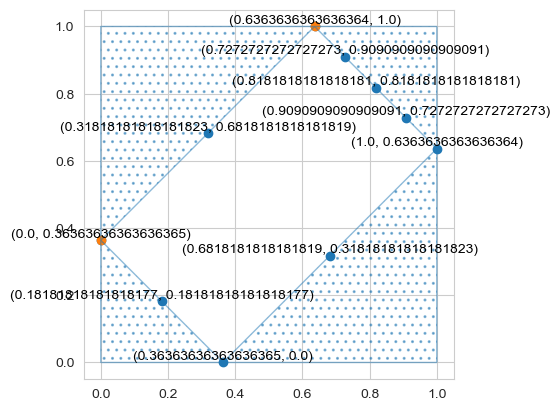

,x,y
0,1.000000,0.636364
1,0.636364,1.000000
2,0.818182,0.818182
3,0.909091,0.727273
4,0.727273,0.909091
5,0.000000,0.363636
6,0.363636,0.000000
7,0.181818,0.181818
8,0.681818,0.318182
9,0.318182,0.681818


In [39]:
tdf = helper.make_restricted_plot(all_targs, num_cells, dev_steps, fitnesses1, fitnesses2, labelled=True)
tdf

In [40]:
helper.calc_div_BH(fitnesses1, fitnesses2, tdf)

1.036523113726489
[6.36363636e-07 8.99954088e-01]
[0.99999939 0.13175686]
[0.99999877 0.01735987]
0.5086793205313442
end of dists --------
0.31818166000000003
1.0


0.7543396602656721

In [37]:
helper.calc_div_BH(fitnesses1, fitnesses2, tdf)

1.036523113726489
[6.36363636e-07 8.99954088e-01]
[0.99999939 0.13175686]
[0.99999877 0.01735987]
0.5086793205313442
end of dists --------
0.31818166000000003
1.0


0.7543396602656721

In [ ]:
#collapses to 1 line only if targ A = 1 - targ B

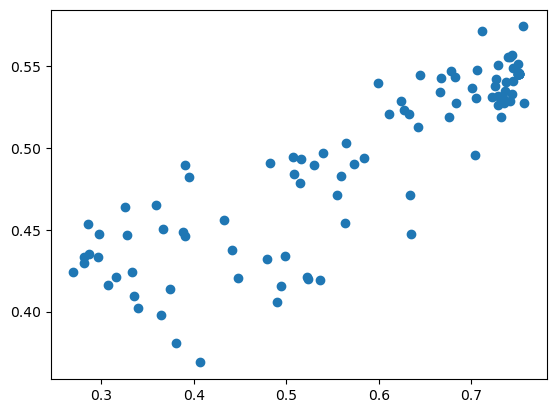

In [112]:
pop = np.random.randn(pop_size, grn_size+2, grn_size).astype(np.float64)
target1, _, fitnesses1 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[0])
target2, _, fitnesses2 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[1])

plt.scatter(fitnesses1,fitnesses2)

#diver_score = dist_maxs + std_2d


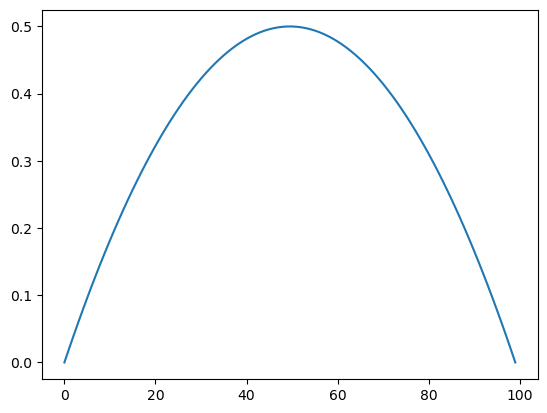

In [65]:
def dist(x, y):
    return np.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1])**2)

a = [0, 0.4]
b = [1, 0.6]
c = [1, 1 - a[0]]
d0 = [0, 1 - b[1]]

#ax1 = dist(a, c)
#ax2 = dist(b, d)

overlapo = 0.9#0.6
error = 1-overlapo#0.4
ls=[]
for i in np.linspace(0,1,100):
    overlapo = i
    error = 1-overlapo
    ls.append(1-(error*error + overlapo*overlapo))

plt.plot(ls)

In [120]:
pop = np.random.randn(pop_size, grn_size+2, grn_size).astype(np.float64)
target1, _, fitnesses1 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[0])
target2, _, fitnesses2 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[1])

pop = np.random.random(size=(pop_size, dev_steps+1, num_cells))
fitnesses1 = -np.abs(pop - target1).sum(axis=1).sum(axis=1)
fitnesses1=1-(fitnesses1/worst) #0-1 scaling
fitnesses2 = -np.abs(pop - target2).sum(axis=1).sum(axis=1)
fitnesses2=1-(fitnesses2/worst) #0-1 scaling

pop = np.random.randint(0, high = 2, size=(pop_size, dev_steps+1, num_cells))
fitnesses1 = -np.abs(pop - target1).sum(axis=1).sum(axis=1)
fitnesses1=1-(fitnesses1/worst) #0-1 scaling
fitnesses2 = -np.abs(pop - target2).sum(axis=1).sum(axis=1)
fitnesses2=1-(fitnesses2/worst) #0-1 scaling


pop_df = pd.DataFrame()
pop_df["x"]=fitnesses1
pop_df["y"]=fitnesses2

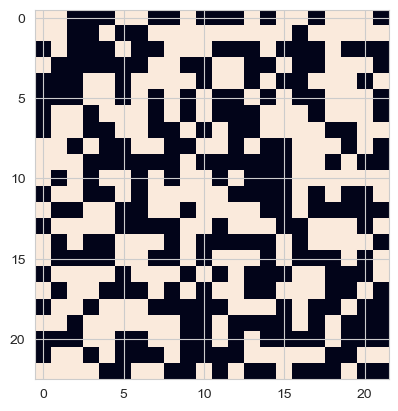

In [121]:
plt.imshow(pop[0])

/Users/csengepetak/miniconda3/envs/grnenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/csengepetak/miniconda3/envs/grnenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/csengepetak/miniconda3/envs/grnenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/csengepetak/miniconda3/envs/grnenv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

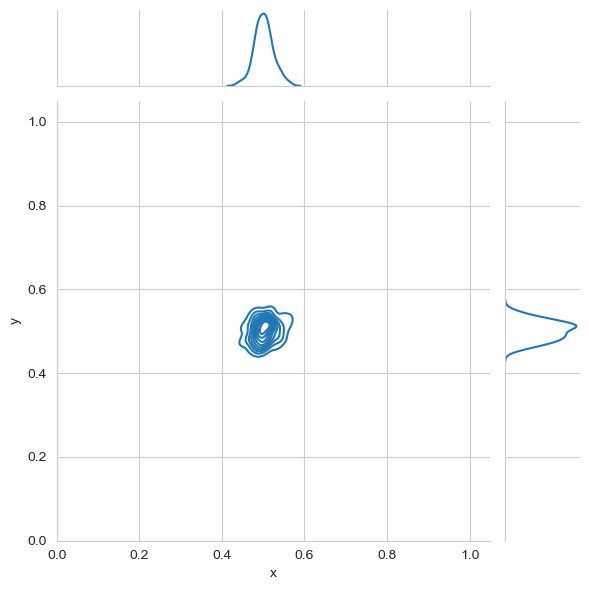

In [122]:
sns.set_style("whitegrid")
jnt = sns.jointplot(data=pop_df, x="x", y="y",kind="kde")

plt.xlim(0,1.05)
plt.ylim(0,1.05)

plt.show()


In [ ]:
#----------------------------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


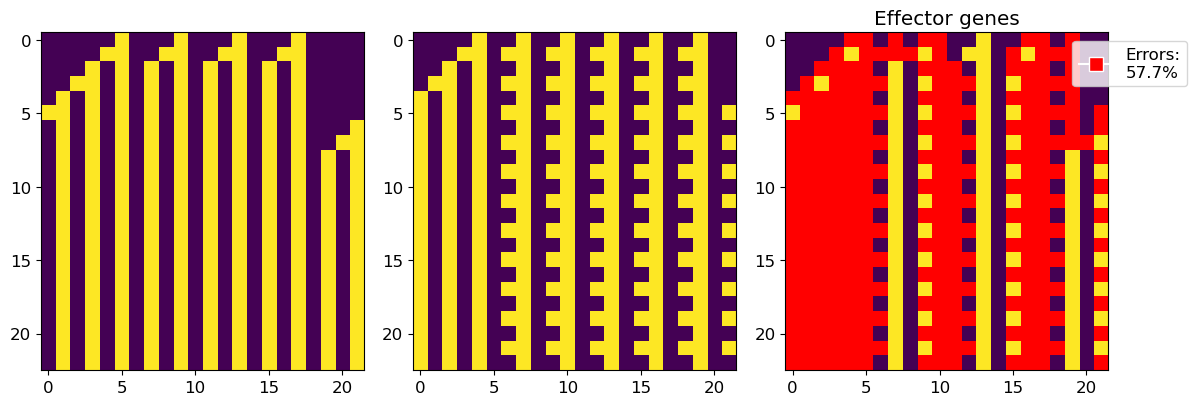

In [124]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
#Plot best phenotype
axs[0].imshow(all_targs[0])
#Plot target
axs[1].imshow(all_targs[1])
#Plot difference
helper.show_effectors(all_targs[0], all_targs[1], M=0, ax=axs[2])

plt.tight_layout()
plt.show()



In [ ]:
fname=f"results_new_rules/stats_300_{rule}-{rule}_69904-149796" + "_" + str(1)
f=np.loadtxt(fname + "_both_fits.txt")
print(f.shape[0]/2/pop_size)
num_generations=int(f.shape[0]/2/pop_size)
f=f.reshape(num_generations,2,pop_size)
f.shape

In [ ]:

for x,i in enumerate(f):
    plt.plot(i[0,:],i[1,:],".")
    xmean=np.mean(i[0,:])
    ymean=np.mean(i[1,:])
    plt.plot(xmean, ymean, "x")
    print(xmean)
    print(np.max(i[0,:]))
    print(saveat[x])
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()

In [ ]:
edges = np.loadtxt("results_testing_saving/stats_300_30-30_1024-1024_0_edges.txt")
  num_generations=int(edges.shape[0]/4/args.pop_size)
  edges = np.reshape(edges, (num_generations*args.pop_size, 2, 2))  

  # ----------------------
  # Parameters
  num_gen_start = 0
  num_gen_stop = 5 #args.num_generations
  num_gens_show = num_gen_stop - num_gen_start
  new_edges = []
  for e in edges:
    if (e[0][0] >= num_gen_start) & (e[0][0] < num_gen_stop):
      #e[0][0] = e[0][0] - num_gen_start
      #e[1][0] = e[1][0] - num_gen_start
      new_edges.append([(e[0][0]- num_gen_start, e[0][1]),(e[1][0]- num_gen_start, e[1][1])])
  edges = new_edges.copy()

  # Set up network
  num_rows = num_gens_show+1
  num_columns = args.pop_size
  G = nx.Graph()
  # Add nodes with specified positions
  pos = {}
  for i in range(num_rows):
      for j in range(num_columns):
          node = (i, j)
          G.add_node(node)
          pos[node] = (j, -i)  # Assigning positions based on rows and columns
  
  # Add edges from the edges variable
  mydic=defaultdict(list) #make dictionary to keep track of OG where it comes from
  for i in range(len(edges)):
    G.add_edge(edges[i][0],edges[i][1])
    if edges[i][0][0] == 0: #if it is the first generation
      mydic[edges[i][0]].append(edges[i][1])
    else:
      for k in mydic.keys():
        if edges[i][0] in mydic[k]:
          mydic[k].append(edges[i][1])

  #coloring
  def generate_colors(n, cmap='viridis'):
    color_map = plt.get_cmap(cmap)
    colors = [color_map(i / n) for i in range(n)]
    return colors
  
  import colorsys
  def generate_colors(n):
    # Generate colors in HSL
    colors = []
    for i in range(n):
        # Generate hue, saturation, and lightness
        hue = i / n  # Normalize hue
        saturation = 0.7  # Set saturation to 70%
        lightness = 0.5  # Set lightness to 50%
        
        # Convert HSL to RGB
        rgb = colorsys.hls_to_rgb(hue, lightness, saturation)
        colors.append(rgb)
    return colors
  
  colors = generate_colors(args.pop_size)
  node_colors = []
  for c in colors:
    node_colors.append(c) #colors for the first generation
  color_dic = {}
  for idx, node in enumerate(G.nodes()):
    if node[0] == 0:
      color_dic[node] = colors[idx] #color assigned to each original parent
  for node in G.nodes():
    if node[0] != 0:
      for k in mydic.keys():
        if node in mydic[k]:
          node_colors.append(color_dic[k]) #assign color based on original parent

  plt.figure(figsize=(12, 8))

  #Draw network
  nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=20, linewidths=0.0)
  nx.draw_networkx_edges(G, pos, node_size=20, alpha=0.1)
  plt.title("Lineages")
  plt.show()

  #Draw matrix
  i=0
  color_matrix = np.zeros((num_rows, num_columns, 3))
  for r in range(num_rows):
    for c in range(num_columns):
      color_matrix[r, c] = node_colors[i]
      i+=1

  color_matrix = np.repeat(color_matrix, 100, axis=0)
  plt.imshow(color_matrix)
  plt.show()

  #Draw trend, num lineages
  pcs = np.reshape(np.array(node_colors),(num_gens_show+1,args.pop_size,3))
  unique_counts = []
  for subarray in pcs:
    unique_subarrays = np.unique(subarray, axis=0)
    unique_counts.append(len(unique_subarrays))

  plt.plot(unique_counts)
  plt.show()